### Imports

In [81]:
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import re
from collections import Counter, defaultdict
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from nltk.util import ngrams
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import math

np.set_printoptions(threshold=np.inf)

### Recogemos los datos limpios

In [2]:
# Cargamos las noticias limpias en df_clean
df_clean = pd.read_csv('../data/train_clean.csv')

### Tokenización

In [3]:
# Tokenizamos el texto
df_clean_tokens = pd.DataFrame()
df_clean_tokens['text'] = df_clean['text'].apply(nltk.word_tokenize)
df_clean_tokens['label'] = df_clean['label']

### Split train/test

In [4]:
# Dividimos el dataset en train y test con la función sample de pandas
df_train, df_test = train_test_split(df_clean_tokens, test_size=0.2, random_state=777)

print("Ejemplos usados para entrenar: ", len(df_train))
print("Ejemplos usados para test: ", len(df_test))

Ejemplos usados para entrenar:  16640
Ejemplos usados para test:  4160


### Etiquetamos texto

In [5]:
# Si label es 0, incluimos en text True, False si es 1
for i in range(len(df_train['label'])):
	if df_train['label'].iloc[i] == 0:
		df_train['text'].iloc[i].append("TRUE")
	else:
		df_train['text'].iloc[i].append("FALSE")
  
df_train = df_train.drop('label', 1)

C:\Users\jabel\AppData\Local\Temp\ipykernel_14112\2436280572.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_train = df_train.drop('label', 1)


### Data Visualization

In [ ]:
# Creamos dos word cloud con el texto limpio y tokenizado de cada label
wordcloud = WordCloud(width=1920, height=1080,
				background_color ='white',
				min_font_size = 10).generate(str(df_clean_tokens['text'][df_clean_tokens['label'] == 0]))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

wordcloud = WordCloud(width=1920, height=1080,
				background_color ='white',
				min_font_size = 10).generate(str(df_clean_tokens['text'][df_clean_tokens['label'] == 1]))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Caso 1: Unigramas

In [ ]:
# Preparamos los datos para procesar Apriori
te1 = TransactionEncoder()
te_ary1 = te1.fit(df_train['text']).transform(df_train['text'])
df_apriori1 = pd.DataFrame(te_ary1, columns=te1.columns_)
df_apriori1

In [ ]:
frecuencias_true = defaultdict(int)
frecuencias_fake = defaultdict(int)

for index, noticia in df_train.iterrows():
	es_verdadera = 'TRUE' in noticia['text']  # Comprobamos si la noticia es verdadera o falsa
	palabras = set(noticia['text'])  # Utilizamos un conjunto para evitar contar varias veces la misma palabra en una noticia
	
	for palabra in palabras:
		if es_verdadera:
			frecuencias_true[palabra] += 1
		else:
			frecuencias_fake[palabra] += 1

# Crear un DataFrame con las frecuencias de palabras en noticias verdaderas
df_true = pd.DataFrame({'Palabra': list(frecuencias_true.keys()), 'Frecuencia_true': list(frecuencias_true.values())})

# Crear un DataFrame con las frecuencias de palabras en noticias falsas
df_fake = pd.DataFrame({'Palabra': list(frecuencias_fake.keys()), 'Frecuencia_fake': list(frecuencias_fake.values())})

# Combinar los DataFrames por la columna 'Palabra'
df_frecs = pd.merge(df_true, df_fake, on='Palabra', how='outer').fillna(0)

In [ ]:
# Obtenemos en una lista las palabras con frecuencia menor a 50
words_less_50 = []
for index, noticia in df_frecs.iterrows():
	if noticia['Frecuencia_true'] + noticia['Frecuencia_fake'] < 50:
		words_less_50.append(noticia['Palabra'])

In [ ]:
words_more_50 = set(df_apriori1.columns.tolist()) - set(words_less_50)
df_apriori1 = df_apriori1[words_more_50]

In [ ]:
# Conjuntos de items frecuentes
itemsets_frecuentes1 = apriori(df_apriori1, min_support=0.2, use_colnames=True)
itemsets_frecuentes1

In [ ]:
itemsets_frecuentes1.count()

In [ ]:
# Reglas de asociación apriori
reglas_unigramas = association_rules(itemsets_frecuentes1, metric="confidence", min_threshold=0.2)
reglas_unigramas

In [ ]:
# Escogemos las reglas que contienen solamente True o solamente False en el consecuente
reglas_VoF1 = reglas_unigramas[(reglas_unigramas['consequents'] == frozenset({'TRUE'})) | (reglas_unigramas['consequents'] == frozenset({'FALSE'}))]
reglas_VoF1.sort_values(by=['confidence'], ascending=False)

In [ ]:
# Vemos las 10 reglas que tienen mayor confianza de las falsas
reglas_F1.sort_values(by=['confidence'], ascending=False).head(10)

In [ ]:
# Vemos las 10 reglas que tienen mayor confianza de las verdaderas
reglas_V1.sort_values(by=['leverage'], ascending=False).head(20)

## Caso 2: N-Gramas

In [6]:
# Definimos get_grams
def get_ngrams(text, n):
	n_grams = ngrams(text, n)
	return [' '.join(grams) for grams in n_grams]

# Creamos un nuevo dataframe donde para cada noticia almacenamos los ngramas de 1 a 3 de longitud
df_train_ngramas = pd.DataFrame()
df_train_ngramas['text'] = df_train['text']
df_train_ngramas['ngrams'] = df_train_ngramas['text'].apply(lambda x: get_ngrams(x, 1)) + df_train_ngramas['text'].apply(lambda x: get_ngrams(x, 2)) + df_train_ngramas['text'].apply(lambda x: get_ngrams(x, 3))

df_test_ngramas = pd.DataFrame()
df_test_ngramas['text'] = df_test['text']
df_test_ngramas['label']	= df_test['label']
df_test_ngramas['ngrams'] = df_test_ngramas['text'].apply(lambda x: get_ngrams(x, 1)) + df_test_ngramas['text'].apply(lambda x: get_ngrams(x, 2)) + df_test_ngramas['text'].apply(lambda x: get_ngrams(x, 3))

# Descartamos los ngramas que incluyan las palabras 'TRUE' o 'FALSE'
df_train_ngramas['ngrams'] = df_train_ngramas['ngrams'].apply(lambda x: [ngram for ngram in x if 'TRUE' not in ngram and 'FALSE' not in ngram])
df_test_ngramas['ngrams'] = df_test_ngramas['ngrams'].apply(lambda x: [ngram for ngram in x if 'TRUE' not in ngram and 'FALSE' not in ngram])

In [7]:
# Creamos un set con todos los ngramas de train
ngramas = []
for i in range(len(df_train_ngramas['ngrams'])):
	ngramas += df_train_ngramas['ngrams'].iloc[i]
ngramas_set = set(ngramas)
len(ngramas_set)

9038599

In [8]:
# BORRAMOS COSAS
del i
del ngramas
del df_clean
del df_clean_tokens
del df_test
del df_test_ngramas

In [9]:
# Contamos la frecuencia de cada ngrama en el conjunto de train como antes
ngramas_counter = defaultdict(int)
for index, noticia in df_train_ngramas.iterrows():
	for ngr in noticia['ngrams']:
		ngramas_counter[ngr] += 1

# Extraemos en una lista los ngramas que aparecen menos de 'umbral' veces
umbral = 50
ngramas_eliminar = []
for ngrama in ngramas_counter:
	if ngramas_counter[ngrama] < umbral:
		ngramas_eliminar.append(ngrama)

# Calculamos cuáles no vamos a eliminar, restando los conjuntos
ngramas_no_eliminar = ngramas_set - set(ngramas_eliminar)

In [10]:
# Vemos el número total de ngramas en cada dataframe
print("Número total de ngramas en el dataframe original: ", len(ngramas_counter))
print("Número total de ngramas en el dataframe limpio: ", len(ngramas_no_eliminar))

Número total de ngramas en el dataframe original:  9038599
Número total de ngramas en el dataframe limpio:  17394


In [11]:
# Creamos un nuevo dataframe donde eliminamos los ngramas que aparecen menos de 'umbral' veces
df_train_ngramas_clean = pd.DataFrame()
df_train_ngramas_clean['text'] = df_train_ngramas['text']
df_train_ngramas_clean['ngrams'] = df_train_ngramas['ngrams'].apply(lambda x: set(x).intersection(ngramas_no_eliminar))

In [12]:
# Nos quedamos con los ngramas maximales, es decir los ngramas que no están contenidos en otros ngramas
ngramas_maximales = set(ngramas_no_eliminar)
for ngrama in ngramas_no_eliminar:
	for ngrama2 in ngramas_no_eliminar:
		if ngrama != ngrama2 and ngrama in ngrama2:
			ngramas_maximales.discard(ngrama)
			break

print("Número total de ngramas maximales: ", len(ngramas_maximales))

Número total de ngramas maximales:  11985


In [64]:
ngramas_maximales

{'evangel',
 'found evid',
 'broken',
 'mingl',
 'local newspap',
 'court file',
 'influenti peopl news',
 'espn',
 'rais possibl',
 'live work',
 'switch vote',
 'radio follow twitter',
 'sunk',
 'state first',
 'white hous correspond',
 'half hour',
 'better job',
 'vision',
 'anoth man',
 'similar',
 'pervers',
 'istanbul',
 'unfound',
 'danger',
 'poem',
 'live near',
 'san suu kyi',
 'preliminari',
 'question said',
 'construct site',
 'poorer',
 'white supremacist',
 'one trump',
 'monica lewinski',
 'intellig communiti',
 'hampton',
 'parallel',
 'bypass',
 'polit process',
 'raider',
 'second term',
 'mayor bill de',
 'presidenti bid',
 'like never',
 'world seri',
 'everi week',
 'want hear',
 'say hillari',
 'stranger',
 'hoffman',
 'fork',
 'three hour',
 'dementia',
 'inner circl',
 'instinct',
 'migrat',
 'campaign trail',
 'remot',
 'retain',
 'neighborhood',
 'human shield',
 'would cover',
 'world bank',
 'obama signatur',
 'use term',
 'board director',
 'million ameri

In [13]:
# BORRAR COSAS
del df_train
del index
del ngr
del ngramas_eliminar
del ngramas_no_eliminar
del ngramas_set
del noticia
del ngramas_counter
del ngrama
del ngrama2

In [14]:
# Creamos un set que contenga los bigramas incluidos en los ngramas maximales
bigramas_maximales = set()
for ngrama in ngramas_maximales:
	split = ngrama.split()
	if len(split) == 2:
		bigramas_maximales.add(ngrama)
	elif len(split) > 2:
		for i in range(len(split)-1):
			bigramas_maximales.add(split[i] + ' ' + split[i+1])

In [15]:
# Creamos una lista de transacciones donde cada transacción es una lista de elementos
transactions = df_train_ngramas_clean['text'].tolist()

# Creamos un TransactionEncoder y lo ajustamos a la lista de transacciones
te = TransactionEncoder()
te.fit(transactions)

# Transformamos las transacciones en una matriz booleana donde las filas representan las transacciones y las columnas representan los elementos
data = te.transform(transactions)

# Creamos un nuevo DataFrame a partir de la matriz booleana y las columnas de elementos correspondientes
df_encoded = pd.DataFrame(data, columns=te.columns_)

In [16]:
# Calculamos los itemsets frecuentes
freq_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True, verbose=1)
freq_itemsets

Processing 154 combinations | Sampling itemset size 765


,support,itemsets
0,0.504026,(FALSE)
1,0.495974,(TRUE)
2,0.304087,(accord)
3,0.269892,(ad)
4,0.538281,(also)
...,...,...
4412,0.223317,"(one, new, year, york, time, said)"
4413,0.203245,"(one, new, year, york, would, time)"
4414,0.210036,"(new, year, york, would, time, said)"
4415,0.201142,"(one, new, TRUE, york, would, time, said)"


In [17]:
# Reglas de asociación
reglas = association_rules(freq_itemsets, metric="confidence", min_threshold=0.2)
reglas

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(also),(FALSE),0.538281,0.504026,0.206611,0.383834,0.761535,-0.064697,0.804935
1,(FALSE),(also),0.504026,0.538281,0.206611,0.409920,0.761535,-0.064697,0.782468
2,(like),(FALSE),0.534014,0.504026,0.229026,0.428877,0.850902,-0.040131,0.868418
3,(FALSE),(like),0.504026,0.534014,0.229026,0.454394,0.850902,-0.040131,0.854069
4,(new),(FALSE),0.584495,0.504026,0.200541,0.343101,0.680720,-0.094060,0.755023
...,...,...,...,...,...,...,...,...,...
40993,(year),"(one, new, TRUE, york, time, said)",0.539062,0.246514,0.203365,0.377258,1.530367,0.070479,1.209947
40994,(TRUE),"(one, new, year, york, time, said)",0.495974,0.223317,0.203365,0.410033,1.836099,0.092606,1.316484
40995,(york),"(one, new, year, TRUE, time, said)",0.388101,0.211178,0.203365,0.524001,2.481326,0.121407,1.657194
40996,(time),"(one, new, year, TRUE, york, said)",0.623077,0.204868,0.203365,0.326389,1.593168,0.075717,1.180402


In [50]:
# Escogemos las reglas que contienen un elemento en el antecedente y otro en el consecuente
reglas_unigramas = reglas[(reglas['antecedents'].apply(lambda x: len(x) == 1)) & (reglas['consequents'].apply(lambda x: len(x) == 1))]

In [51]:
# Creamos una función que diga si una cadena de caracteres es un substring de un ngrama maximal
def is_in_maximal(cadena):
	return cadena in bigramas_maximales

In [52]:
# Escogemos las reglas cuyo antecedente y consecuente conjuntamente pertenecen a algun ngrama maximal
reglas_intermedias = reglas_unigramas[	reglas_unigramas.apply(lambda x: is_in_maximal(list(x['antecedents'])[0] + ' ' + list(x['consequents'])[0]), axis=1)	]

In [53]:
reglas_intermedias

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
104,(accord),(new),0.304087,0.584495,0.219832,0.722925,1.236836,0.042095,1.499611
107,(accord),(one),0.304087,0.617248,0.227584,0.748419,1.212510,0.039887,1.521388
108,(said),(accord),0.620553,0.304087,0.233894,0.376913,1.239491,0.045192,1.116879
111,(state),(accord),0.507692,0.304087,0.200421,0.394768,1.298209,0.046038,1.149829
116,(year),(accord),0.539062,0.304087,0.207873,0.385619,1.268122,0.043951,1.132706
...,...,...,...,...,...,...,...,...,...
2007,(would),(work),0.544772,0.395853,0.285036,0.523221,1.321755,0.069386,1.267142
2008,(work),(year),0.395853,0.539062,0.286418,0.723546,1.342231,0.073029,1.667323
2009,(year),(work),0.539062,0.395853,0.286418,0.531327,1.342231,0.073029,1.289057
2012,(world),(would),0.321334,0.544772,0.225481,0.701702,1.288066,0.050427,1.526085


In [54]:
# Definimos las palabras maximales como aquellas que se encuentran en los ngramas maximales
palabras_maximales = set()
for ngrama in ngramas_maximales:
	split = ngrama.split()
	for palabra in split:
		palabras_maximales.add(palabra)

In [55]:
# Escogemos las reglas que contienen solamente True o solamente False en el consecuente, y en el antecedente hay una palabra contenida en un ngrama maximal
reglas_V = reglas_unigramas[reglas_unigramas['consequents'] == frozenset({'TRUE'})]
reglas_V = reglas_V[reglas_V.apply(lambda x: list(x['antecedents'])[0] in palabras_maximales, axis=1)]
reglas_V.sort_values(by=['confidence'], ascending=False)
reglas_F = reglas_unigramas[reglas_unigramas['consequents'] == frozenset({'FALSE'})]
reglas_F = reglas_F[reglas_F.apply(lambda x: list(x['antecedents'])[0] in palabras_maximales, axis=1)]
reglas_F.sort_values(by=['confidence'], ascending=False)

# Agrupamos las reglas verdaderas y falsas en un solo dataframe
reglas_VoF = pd.DataFrame()
reglas_VoF = reglas_V.append(reglas_F)
reglas_VoF
reglas_VoF.sort_values(by=['confidence'], ascending=False)

C:\Users\jabel\AppData\Local\Temp\ipykernel_14112\1812903541.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reglas_VoF = reglas_V.append(reglas_F)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
59,(mr),(TRUE),0.275481,0.495974,0.241827,0.877836,1.769925,0.105196,4.125816
101,(york),(TRUE),0.388101,0.495974,0.327524,0.843915,1.701531,0.135036,3.229169
93,(week),(TRUE),0.311298,0.495974,0.209856,0.674131,1.359208,0.055460,1.546716
73,(said),(TRUE),0.620553,0.495974,0.414603,0.668119,1.347087,0.106826,1.518698
48,(last),(TRUE),0.398137,0.495974,0.264123,0.663396,1.337564,0.066657,1.497388
63,(new),(TRUE),0.584495,0.495974,0.383954,0.656899,1.324464,0.094060,1.469032
46,(includ),(TRUE),0.381490,0.495974,0.246514,0.646188,1.302867,0.057305,1.424559
69,(presid),(TRUE),0.423738,0.495974,0.268149,0.632818,1.275911,0.057986,1.372688
53,(made),(TRUE),0.342488,0.495974,0.213942,0.624671,1.259484,0.044077,1.342892
41,(follow),(TRUE),0.337440,0.495974,0.208774,0.618700,1.247445,0.041413,1.321863


In [56]:
# Obtenemos una lista con los antecedentes de las reglas VoF
antecedentes_VoF = reglas_VoF['antecedents'].tolist()

In [58]:
# Creamos una función que vea si hay una regla en reglas_intermedias con el antecedente y consecuente que le pasamos
def is_in_reglas_intermedias(antecedente, consecuente):
	return (antecedente, consecuente) in reglas_intermedias.apply(lambda x: (list(x['antecedents'])[0], list(x['consequents'])[0]), axis=1).tolist()

In [62]:
# Escogemos las palabras conectadas con True o False
palabras_conectadas = set()
nuevas = set([list(x)[0] for x in reglas_VoF['antecedents']])
while len(nuevas) > 0:
    palabras_conectadas.update(nuevas)
    palabras_conectadas_aux = nuevas.copy()
    nuevas = set()
    for ant in palabras_conectadas_aux:
        nuevas.update(set(reglas_intermedias[reglas_intermedias.apply(lambda x: list(x['consequents'])[0] == ant, axis=1)]['antecedents'].apply(lambda x: list(x)[0]).tolist()))
    nuevas.difference_update(palabras_conectadas)

In [63]:
len(palabras_conectadas)

78

In [65]:
# Nos quedamos con las reglas donde tanto el antecedente como el consecuente son palabras conectadas
reglas_conectadas = reglas_intermedias[reglas_intermedias.apply(lambda x: list(x['antecedents'])[0] in palabras_conectadas and list(x['consequents'])[0] in palabras_conectadas, axis=1)]

In [66]:
len(reglas_conectadas)

653

In [77]:
max(reglas_conectadas['confidence'])

0.9982966862805822

In [88]:
max(reglas_conectadas['lift'])

2.5494650629965334

### Grafo de Asociación

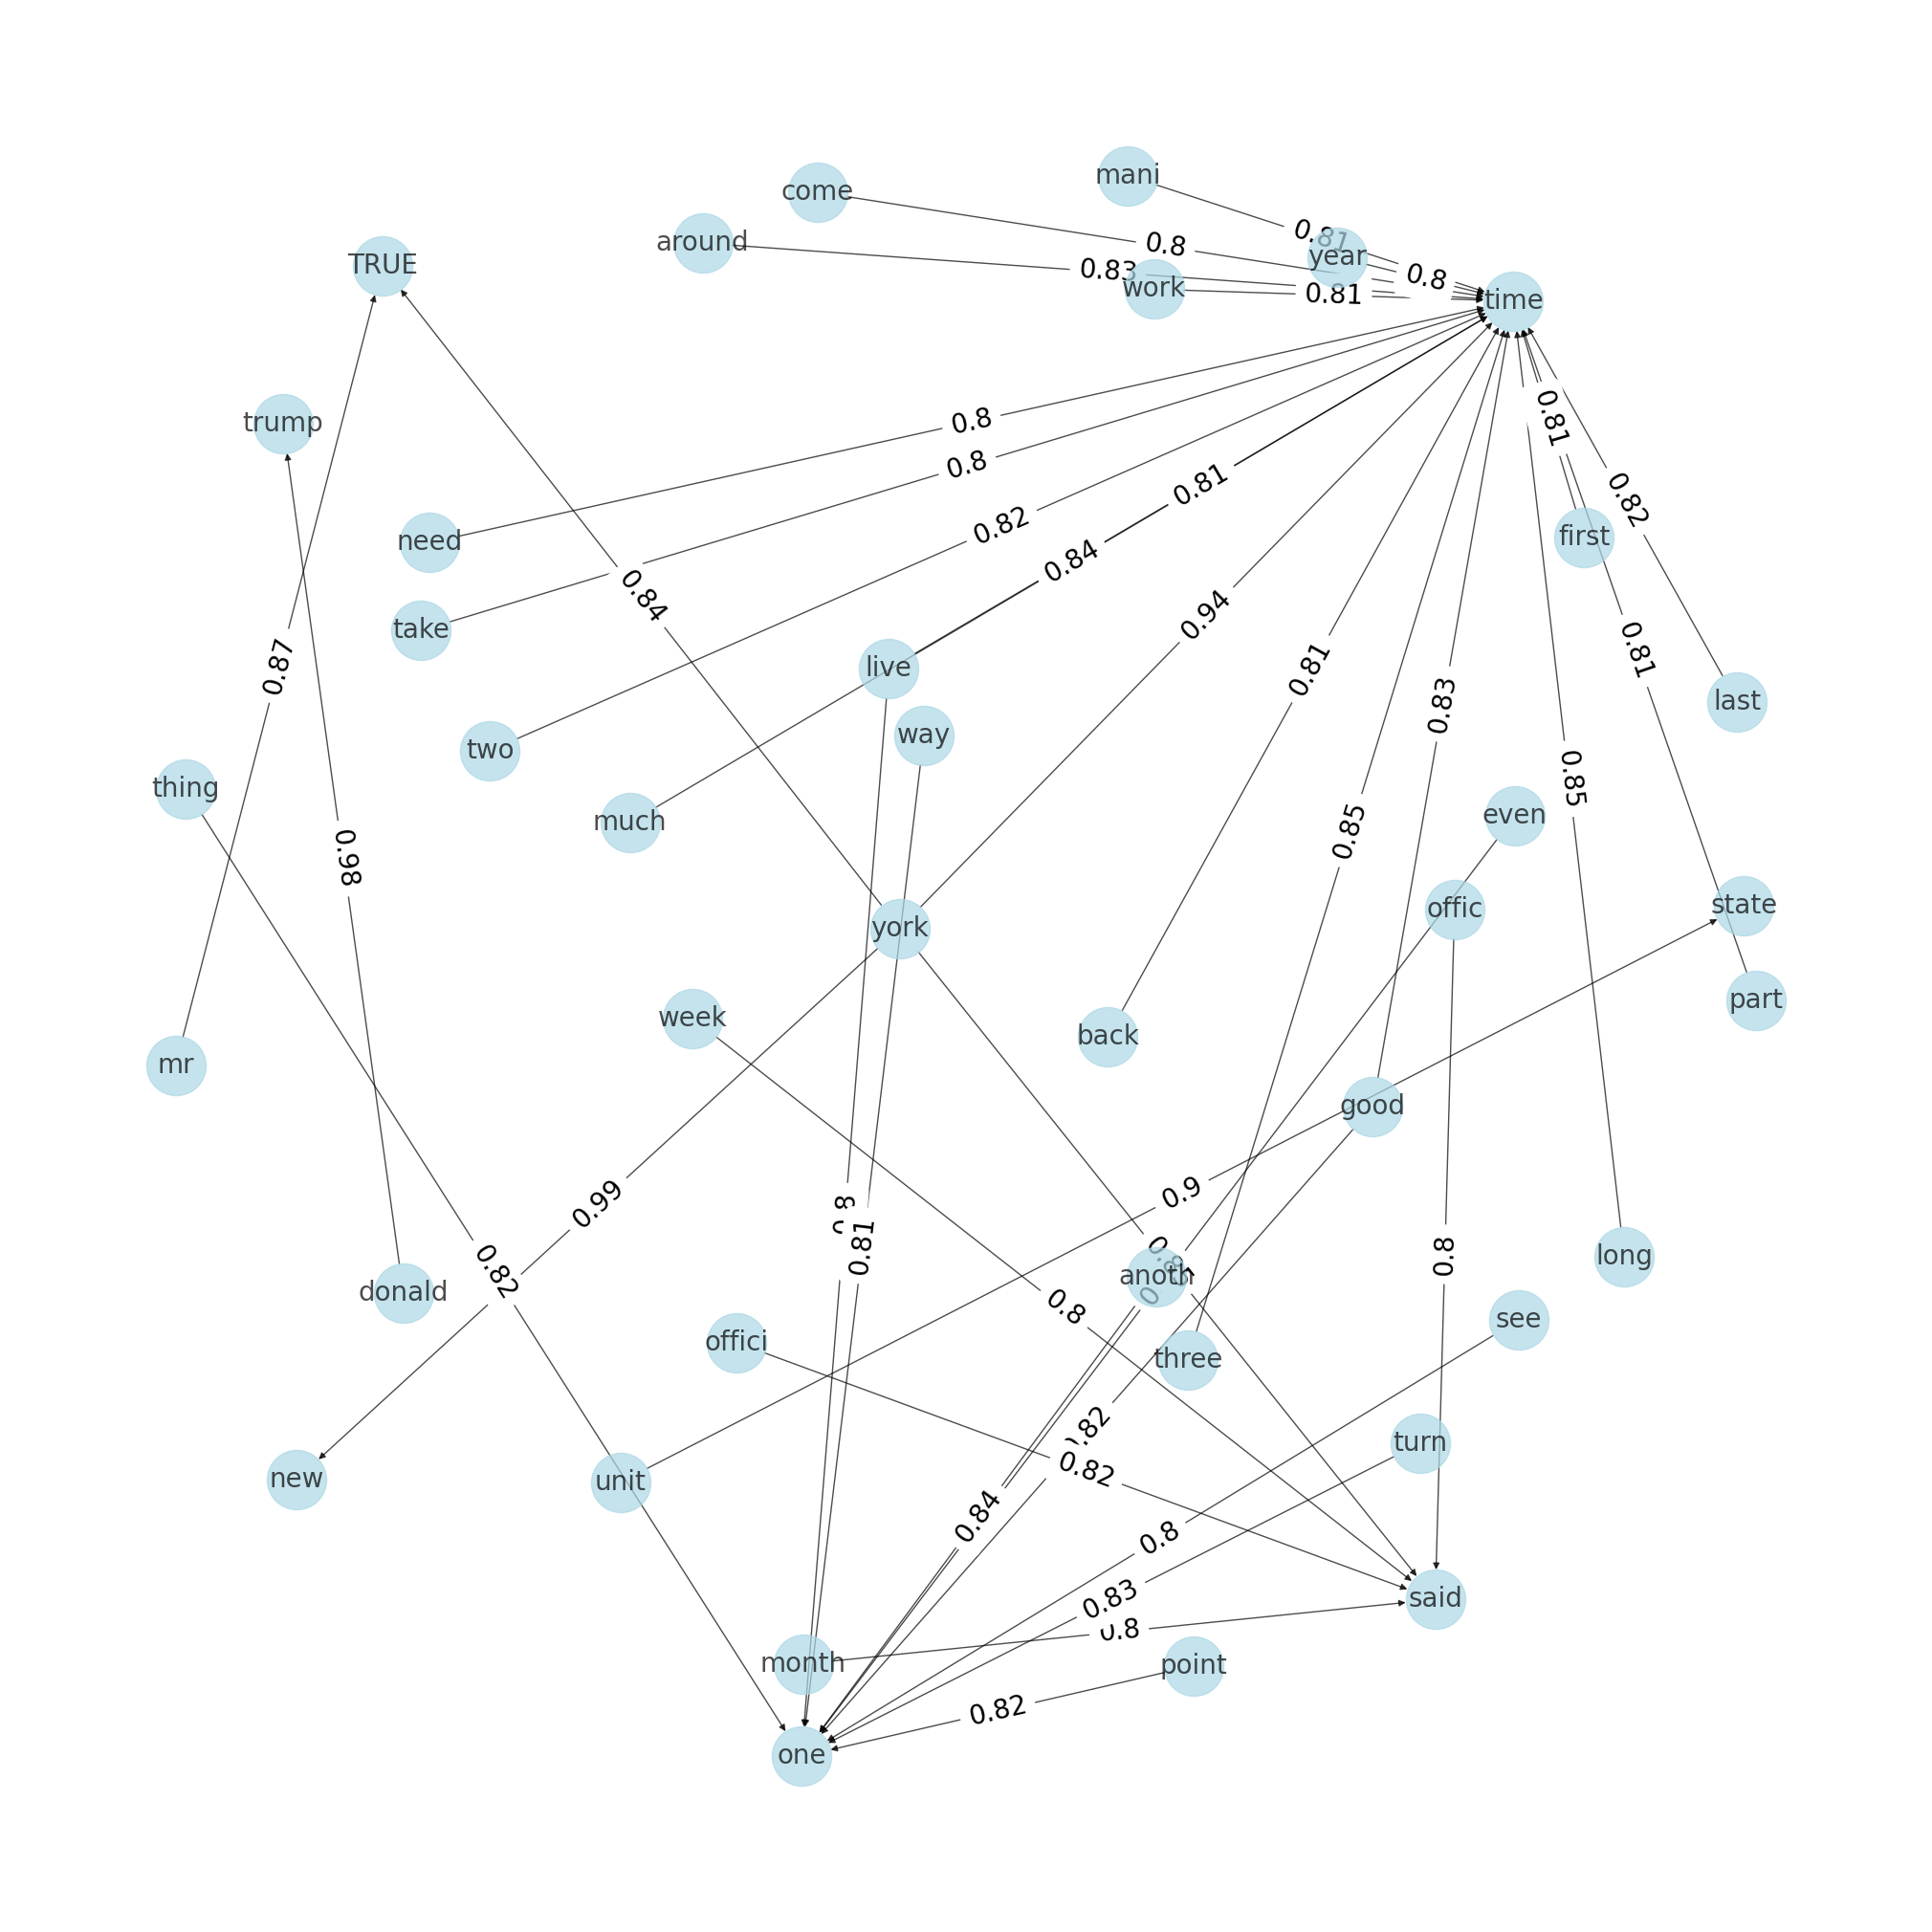

In [128]:
decimales = 2

# Seleccionamos las reglas que tienen una confianza grande
reglas_VoF_grafo = reglas_VoF[reglas_VoF['confidence'] > 0.8]
reglas_conectadas_grafo = reglas_conectadas[reglas_conectadas['confidence'] > 0.8]

# Creamos un grafo de las reglas, donde los nodos son los elementos y las aristas son las reglas, y el valor de la arista es la confianza
G = nx.DiGraph()

# Añadimos los nodos
for i in range(len(reglas_conectadas_grafo)):
    G.add_node(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_conectadas_grafo['consequents'].iloc[i])))

for i in range(len(reglas_VoF_grafo)):
    G.add_node(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])))
    G.add_node(next(iter(reglas_VoF_grafo['consequents'].iloc[i])))

# Añadimos las aristas con la confianza como peso
for i in range(len(reglas_conectadas_grafo)):
    G.add_edge(next(iter(reglas_conectadas_grafo['antecedents'].iloc[i])),
               next(iter(reglas_conectadas_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_conectadas_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

for i in range(len(reglas_VoF_grafo)):
    G.add_edge(next(iter(reglas_VoF_grafo['antecedents'].iloc[i])),
               next(iter(reglas_VoF_grafo['consequents'].iloc[i])),
               weight=math.floor(reglas_VoF_grafo['confidence'].iloc[i] * 10 ** decimales) / 10 ** decimales)

# Dibujamos el grafo
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=1, weight='weight')  # Ajusta el valor de k según tus necesidades
nx.draw(G, pos, with_labels=True, font_size=20, node_size=2000, node_color='lightblue', edge_color='black', width=1, alpha=0.7)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20)

plt.show()

In [89]:
# Comprobamos si el grafo tiene ciclos
nx.is_directed_acyclic_graph(G)

True